this notebook serves as validation of the 'group GLM' class for parallel fitting of models. 

In [6]:
import tensorflow as tf
import numpy as np
#imports
from scipy.stats import norm, gamma
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from glm_utils import *

eps = 1e-3
num_neurons = 10
num_features = 20
T = 1000
stim = np.random.normal(0, scale = 1, size = [T, num_features])

weight_mat = np.zeros([num_features, num_neurons])
weight_inits = np.zeros_like(weight_mat)
y = np.zeros([T, num_neurons])

for i in range(num_neurons):
    s, w, t = generate_data(T, num_features, filt_amp = np.random.uniform(5, 15), c = 3, scale = 5,
                            noise_model='gaussian', non_lin = sigmoid, stim = stim)

    weight_mat[:, i] = w
    weight_inits[:, i] = np.linalg.pinv(s).dot(t)
    
    y[:, i] = t

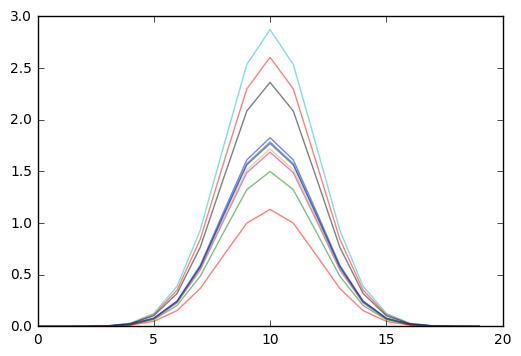

In [132]:
plt.plot(weight_mat, alpha = .5);

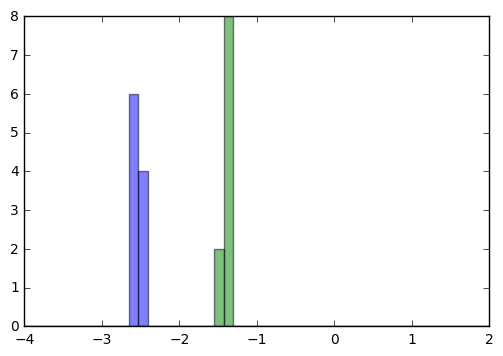

In [8]:
offset =  np.min(y) - eps
#offset = 0
y -= offset

c_int = cond_int(sigmoid, weight_mat, stim, 5, 3, nls = -offset/5)

gLL = 1./T * sum(np.log(norm(0, 1).pdf(y - c_int)))
eLL = 1./T * sum(np.log(gamma.pdf(y, 1, scale = c_int)))

bins = np.linspace(-4, 2, 50)

plt.hist(gLL, bins = bins, color = 'g', alpha = .5);
plt.hist(eLL, bins = bins, color = 'b', alpha = .5);

0%                          100%
[******************************] | ETA: 00:00:00
Total time elapsed: 00:00:01


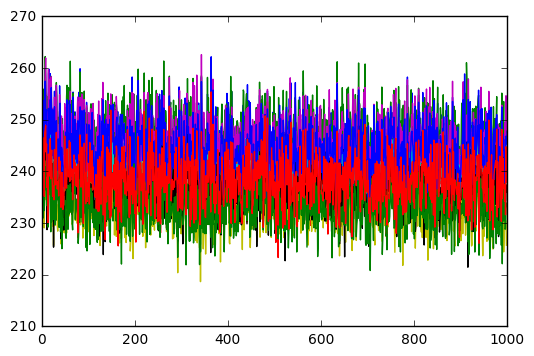

In [105]:
import group_glm as gm
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(stim[:, 0:num_features], y)

weight_init = np.linalg.pinv(X_train).dot(y_train) 

model = gm.exponential_GLM(weight_init, non_lin = 'sigmoid', offset_init = -offset/5. *np.ones([num_neurons]) , scale_init= 5.0*np.ones([num_neurons]), bias_init = 3,
                        train_params = False, lr = 5e-3, alpha = 0)


L, l = model.fit(X_train,y_train,X_test, y_test, max_iters = 1000, batch_size= 100)

w, o, nl, s = model.get_params()
w = w.reshape(num_features, num_neurons)

plt.plot(L);
plt.show()


In [121]:
mi, ma = mad_scaling(y)

In [9]:
from fit_utils import fit_glm_CV

scores, features = fit_glm_CV(y, stim, learning_rate = [5e-3],  
                              offset_init = -offset *np.ones([num_neurons]) , 
                              scale_init= np.ones([num_neurons]), bias_init = .1*np.ones([num_neurons]), 
                              num_pcs = [num_features],debug = False, max_iters= 1000, 
                              batch_size = 500, noise_model = ['exponential','gaussian'])

0%  100%
[#   ] | ETA: 00:00:00

Fitting:  exponential  noise model with:  exp  non-linearity, and:  20 features


InternalError: Blas SGEMM launch failed : a.shape=(500, 20), b.shape=(20, 10), m=500, n=10, k=20
	 [[Node: MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_Placeholder_0/_5, weights/read)]]
	 [[Node: Sum/_7 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_105_Sum", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
Caused by op u'MatMul', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/amy/.local/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/amy/.local/lib/python2.7/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/home/amy/.local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/amy/.local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/amy/.local/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/amy/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/amy/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/amy/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/amy/.local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/amy/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/amy/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/amy/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/amy/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/amy/.local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/amy/.local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/amy/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/amy/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/amy/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-8e20e7250ed0>", line 7, in <module>
    batch_size = 500, noise_model = ['exponential','gaussian'])
  File "fit_utils.py", line 80, in fit_glm_CV
    verbose = False, offset_init = offset_init, scale_init= scale_init, bias_init = bias_init)
  File "group_glm.py", line 171, in __init__
    reg, alpha, non_lin, scale_init, verbose, cap_grads)
  File "group_glm.py", line 69, in __init__
    self.log_loss = self._logloss()
  File "group_glm.py", line 182, in _logloss
    self.fx = tf.matmul(self.design_, self.weights) - self.offset
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_ops.py", line 1209, in matmul
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_math_ops.py", line 1178, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/op_def_library.py", line 704, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2260, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1230, in __init__
    self._traceback = _extract_stack()


In [139]:
t_per_exp = []
t_per_gaus = []

t_per_l_exp = []
t_per_l_sig = []
t_per_l_sr = []

le_all = []
lg_all = []

distrib_n_pcs = []
distrib_lr = []

weights = []

scores[~np.isfinite(scores)] = -np.inf  


n_cells, n_nl, n_nm, npcs, n_lr = scores.shape

best_noise_model = []
best_non_linearity = []

likelihood_exponential = []
likelihood_gaussian = [] 

for i in range(n_cells):
    idx = np.argmax(scores[i])

    nl_ind, nm_ind, pc_ind, lr_ind = np.unravel_index(idx, (n_nl, n_nm, npcs, n_lr))

    if np.isfinite(scores[i, nl_ind, nm_ind, pc_ind, lr_ind]):
        best_noise_model.append(nm_ind)
        best_non_linearity.append(nl_ind)
        #distrib_n_pcs.append(pc_dict[pc_ind])
        distrib_lr.append(lr_ind)
        #weights.append(features[i, 0, 0, 0, 0, 0:num_features])
        weights.append(features[i, nl_ind, nm_ind, pc_ind, lr_ind, 0:num_features])

    else:
        print "Help non-finite likelihood"

weights = np.array(weights)
        
best_noise_model = np.array(best_noise_model)
best_non_linearity = np.array(best_non_linearity)

per_exp = sum(best_noise_model == 0) / float(len(best_noise_model))
per_gaus = sum(best_noise_model == 1) / float(len(best_noise_model))

per_l_exp = sum(best_non_linearity == 0) / float(len(best_non_linearity))
per_l_sig = sum(best_non_linearity == 1) / float(len(best_non_linearity))
per_l_sr = sum(best_non_linearity == 2) / float(len(best_non_linearity))

t_per_exp.append(per_exp)
t_per_gaus.append(per_gaus)

t_per_l_exp.append(per_l_exp)
t_per_l_sig.append(per_l_sig)
t_per_l_sr.append(per_l_sr)

le = np.array(scores[:, 1, 0, :].flatten())
#le = le[np.isfinite(le)] 
lg = np.array(scores[:, 1, 1, :].flatten())
#lg = lg[np.isfinite(lg)]
le_all.append(le)
lg_all.append(lg)    



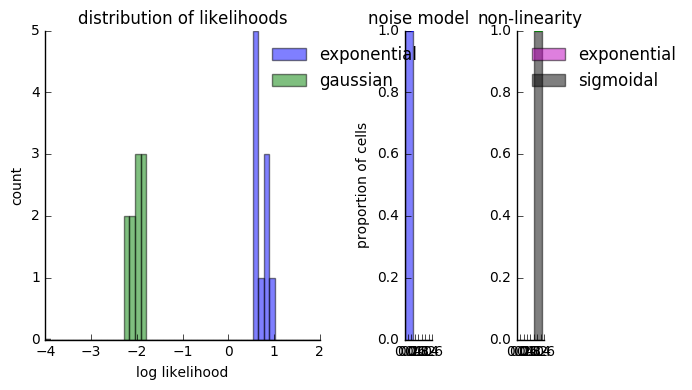

In [142]:
le_all_t = []
lg_all_t = []

for i in range(len(le_all)):
    for j in range(len(le_all[i])):
        le_all_t.append(le_all[i][j])

        
for i in range(len(lg_all)):
    for j in range(len(lg_all[i])):
        lg_all_t.append(lg_all[i][j])
 

le_all_hi = np.array(le_all_t)
le_all_hi = le_all_hi[np.isfinite(le_all_hi)]
lg_all_hi = np.array(lg_all_t).flatten()
lg_all_hi = lg_all_hi[np.isfinite(lg_all_hi)]

bins = np.linspace(-4, 2, num = 50)

plt.figure(figsize = [20, 3])
 
f, (a0, a1, a2) = plt.subplots(1,3, gridspec_kw = {'width_ratios':[10, 1, 1]})    
    
a0.hist(le_all_hi, alpha = .5, label = 'exponential', bins = bins);
a0.hist(lg_all_hi, alpha = .5, label = 'gaussian', bins = bins);
a0.set_ylabel('count')
a0.set_xlabel('log likelihood')
#a0.legend()
simpleaxis(a0, bottom = False)
a0.set_title('distribution of likelihoods')

a1.bar(0, np.mean(t_per_exp), yerr = np.std(t_per_exp),color = 'b', alpha = .5, width = .5,  label = "exponential")
a1.bar(1, np.mean(t_per_gaus), yerr = np.std(t_per_gaus), color = 'g', alpha = .5, width = .5, label = "gaussian")
a1.set_ylabel('proportion of cells')
a1.legend(loc = 'upper right', frameon = False)
a1.set_title('noise model')
simpleaxis(a2, bottom = False)

a2.bar(0, np.mean(t_per_l_exp), yerr = np.std(t_per_l_exp), width = .5, color = 'm', alpha = .5, label = "exponential")
a2.bar(1, np.mean(t_per_l_sig), yerr = np.std(t_per_l_sig),width = .5, color = 'k', alpha = .5, label = "sigmoidal")
a2.set_title('non-linearity')
a2.legend(loc ='upper left', frameon = False)
simpleaxis(a1, bottom = False)



f.tight_layout()

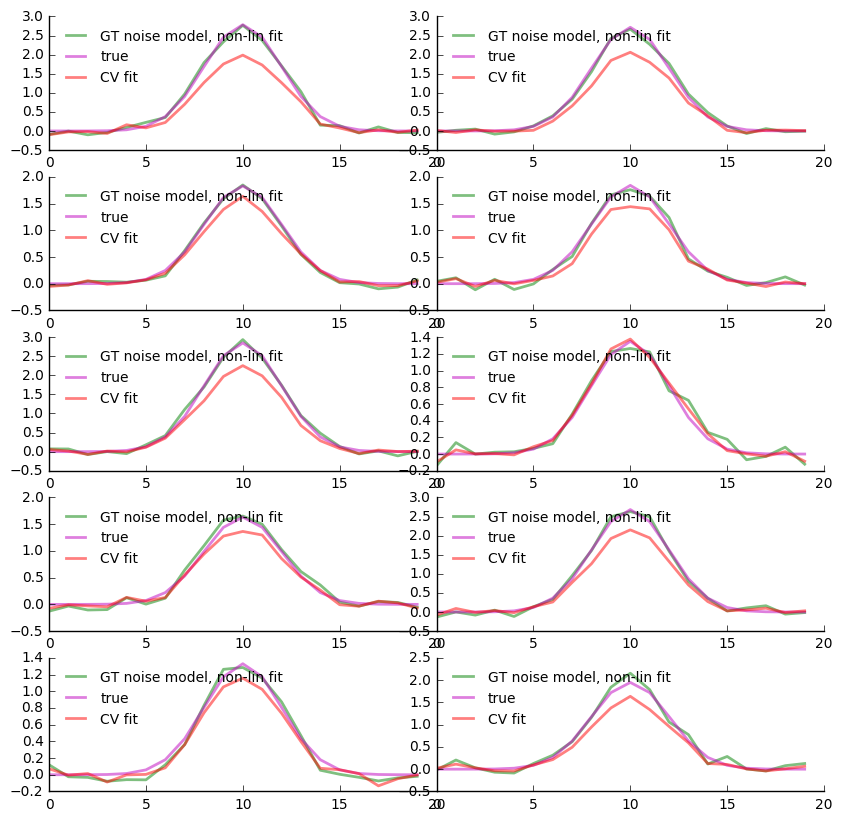

In [130]:
num_rows, num_cols = 5, 2


plt.figure(figsize = [10, 10])
gs, ax = gridplot(num_rows, num_cols)

for i, axes in enumerate(ax):
    axes.plot(w[:, i], c = 'g', linewidth = 2, alpha = .5, label = 'GT noise model, non-lin fit')
    #axes.plot(weight_inits[:, i], c = 'g', linewidth = 1, alpha = .5, label = 'inits')
    axes.plot(weight_mat[:, i], c = 'm', linewidth = 2, alpha = .5, label = 'true')
    axes.plot(weights[i, :], c = 'r', linewidth = 2, alpha = .5, label = 'CV fit')
    axes.legend(fontsize = 10, loc = 'upper left', frameon = False)
    simpleaxis(axes)

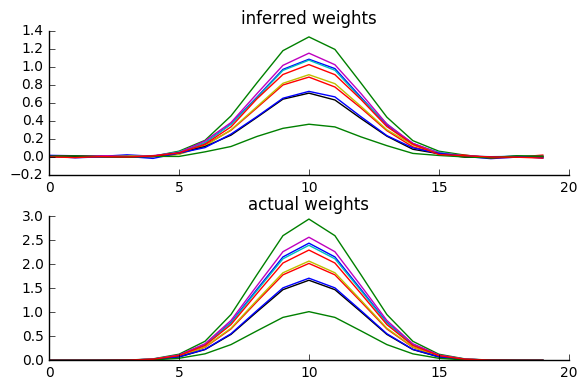

In [48]:
ax = plt.subplot(211)
plt.tight_layout()
plt.plot(w);
plt.title('inferred weights')
simpleaxis(ax)

ax = plt.subplot(212)
plt.tight_layout()
plt.plot(weight_mat);
plt.title('actual weights')
simpleaxis(ax)

NameError: name 'scale_true' is not defined

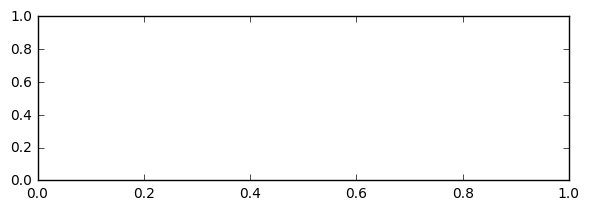

In [35]:
ax = plt.subplot(211)
plt.tight_layout()
plt.scatter(scale_true, s)
plt.xlabel('true scale factor')
plt.ylabel('inferred scale')
simpleaxis(ax)

ax = plt.subplot(212)
plt.tight_layout()
plt.scatter(offset_true, o)
plt.xlabel('true offset')
plt.ylabel('inferred offset')
simpleaxis(ax)

In [2]:
median_arr = []

for i in range(5000):
    sample = np.random.normal(0, 1, size = [100])
    
    median_arr.append(np.median(sample))
    

The standard deviation of the sample medians is:  0.124323748338
The mean of the sample medians is:  -1.59288110646e-05


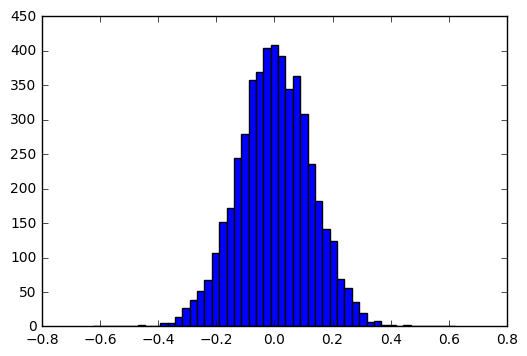

In [9]:
import matplotlib.pyplot as plt

print "The standard deviation of the sample medians is: ", np.std(median_arr)
print "The mean of the sample medians is: ", np.mean(median_arr)

bins = np.linspace(-5*np.std(median_arr), 5*np.std(median_arr))

plt.hist(median_arr, bins = bins);